# PROJECT DEFINITION:
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

# DATA PREPARATION:
### 1) Import Libraries
### 2) Read and Explore Data
    a) info()
    b) head()
    c) Active & Churned Customer Patterns

### 3) Combine all Data Frames
    a) add df_contract['churn_risk']
    b) add df_contract['tenure_category']
    c) merge()
    d) groupby('Type'); describe()
    e) groupby('SeniorCitizen'); ['churn_risk'].value_counts()
    
### 4) Analyze Date Ranges:
    a) sort_values(by='BeginDate')
    b) sort_values(by='EndDate')
    
# DATA CLEANING (MODEL PRE-PROCESSING):
### 1) Fix Data Types; Missing Customers
    a) TotalCharges Type change
    b) Address df_internet missing values
    c) df_phone missing values
    
### 2) Binary Target and Feature Matrix Creation
    a) Create Churn indicator
    b) Create Feature Matrix
    c) Create X, Y variables
    d) Check then handle Missing Values

### 3) Category Encoding
    a) Check for categorical features
    b) Mixed Encoding
    c) Verify Encoding by value_counts()
    
# Model Training:
### 1) Create train-test split
    a) Use 80/20 ratio split

### 2) Create Random Forest Model
    a) Random Forest Model
    b) Baseline Model Evaluation (Accuracy, AUC-ROC, Classification Report, Confusion Matrix)
    c) GridSearchCV (TEST AND VALIDATION DATASET) Model and Evaluation
    d) FINAL (TEST DATASET) GridSearchCV Model and Evaluation
    e) Feature Analysis

# Model Analysis:
### 1) Create a TABLE to display the results
    a) Document model analysis results

In [1]:
## DATA PREPARATION
## OUTLINE 1 - Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score, classification_report, roc_auc_score, confusion_matrix
import time
#from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
## DATA PREPARATION
##  OUTLINE 2 - Read and Explore Data
##  QUESTION #1 - What patterns are found:
##  Answer (i) - info(), head():

# DF_CONTRACT
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
#df_contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col=[1], parse_dates=[1])

print('DF_CONTRACT:')
print('INFO():')
print(df_contract.info())
print()
print('HEAD():')
print(df_contract.head())
print()
 

DF_CONTRACT:
INFO():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

HEAD():
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  92

In [3]:
## DATA PREPARATION
##  OUTLINE 2 - Read and Explore Data
##  QUESTION #1 - What patterns are found:
##  Answer (i) - Active & Churned Customer Patterns:

## Active Customers
df_contract.sort_index(inplace=True)
df_active_customers = df_contract[df_contract['EndDate'] == 'No']

vtotal_customers = len(df_contract)
vactive_customers = len(df_active_customers)

## Churned Customers
vchurned_customers = vtotal_customers - vactive_customers

vactive_customers_perc = vactive_customers/vtotal_customers
vchurned_customers_perc = vchurned_customers/vtotal_customers

print('ACTIVE & CHURNED CUSTOMER PATTERNS:')
print('Total Customers -', vtotal_customers)
print('Active Customers ONLY -', vactive_customers, f"({vactive_customers_perc:.3f}%)")

print('Churned Customers ONLY -', vchurned_customers, f"({vchurned_customers_perc:.3f}%)")


ACTIVE & CHURNED CUSTOMER PATTERNS:
Total Customers - 7043
Active Customers ONLY - 5174 (0.735%)
Churned Customers ONLY - 1869 (0.265%)


In [4]:
## DATA PREPARATION
##  OUTLINE 2 - Read and Explore Data
##  QUESTION #1 - What patterns are found:
##  Answer (i) - Active & Churned Customer Patterns:

# For active customers (EndDate = 'No')
snapshot_date = pd.to_datetime('2020-02-01', errors='coerce')
active_mask = df_contract['EndDate'] == 'No'
df_contract.loc[active_mask, 'BeginDate'] = pd.to_datetime(df_contract.loc[active_mask, 'BeginDate'], errors='coerce')
#df_contract.loc[active_mask, 'tenure_days'] = (snapshot_date - df_contract.loc[active_mask, 'BeginDate']).dt.days
# Convert snapshot_date to a Series for vectorized operations
snapshot_series = pd.Series([snapshot_date] * active_mask.sum(), index=df_contract[active_mask].index)
df_contract.loc[active_mask, 'tenure_days'] = (snapshot_series - df_contract.loc[active_mask, 'BeginDate']).dt.days

# For churned customers
churned_mask = df_contract['EndDate'] != 'No'
df_contract.loc[churned_mask, 'BeginDate'] = pd.to_datetime(df_contract.loc[churned_mask, 'BeginDate'], errors='coerce')
df_contract.loc[churned_mask, 'EndDate_datetime'] = pd.to_datetime(df_contract.loc[churned_mask, 'EndDate'], errors='coerce')
df_contract.loc[churned_mask, 'churn_days'] = (df_contract.loc[churned_mask, 'EndDate_datetime'] - df_contract.loc[churned_mask, 'BeginDate']).dt.days


/.venv/lib/python3.9/site-packages/pandas/core/arrays/datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [5]:
## DATA PREPARATION
##  OUTLINE 2 - Read and Explore Data
##  QUESTION #1 - What patterns are found:
##  Answer (ii) - info(), head():

# DF_INTERNET
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

print('DF_INTERNET:')
print('INFO():')
print(df_internet.info())
print()
print('HEAD():')
print()
print(df_internet.head())
print()


DF_INTERNET:
INFO():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

HEAD():

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes

In [6]:
## DATA PREPARATION
##  OUTLINE 2 - Read and Explore Data
##  QUESTION #1 - What patterns are found:
##  Answer (ii) - info(), head():

# DF_PHONE
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

print('DF_PHONE:')
print('INFO():')
print(df_phone.info())
print()
print('HEAD():')
print(df_phone.head())
print()


DF_PHONE:
INFO():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

HEAD():
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes



In [7]:
## DATA PREPARATION
##  OUTLINE 2 - Read and Explore Data
##  QUESTION #1 - What patterns are found:
##  Answer (ii) - info(), head():

# DF_PERSONAL
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

print('DF_PERSONAL:')
print('INFO():')
print(df_personal.info())
print()
print('HEAD():')
print(df_personal.head())
print()


DF_PERSONAL:
INFO():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

HEAD():
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No



In [8]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (iii & iv) - Create sensitivity visualizations

# Create churn risk categories based on tenure and charges
def identify_churn_risk(row):
    if pd.isna(row['tenure_days']):
        return 'Already Churned'
    
    tenure_days = row['tenure_days']
    monthly_charges = row['MonthlyCharges']
    
    # High risk: New customers with high charges
    if tenure_days < 365 and monthly_charges > 70:
        return 'Very High Risk'
    # Medium-high risk: Short tenure, medium-high charges
    elif tenure_days < 730 and monthly_charges > 60:
        return 'High Risk'
    # Medium risk: Moderate tenure, high charges
    elif tenure_days < 1095 and monthly_charges > 80:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df_contract['churn_risk'] = df_contract.apply(identify_churn_risk, axis=1)


In [9]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (iii & iv) - Create sensitivity visualizations

# Create tenure categories
def categorize_tenure(days):
    if pd.isna(days):
        return 'Churned'
    elif days < 365:
        return 'New (< 1 year)'
    elif days < 730:
        return 'Established (1-2 years)'
    elif days < 1095:
        return 'Loyal (2-3 years)'
    else:
        return 'Very Loyal (3+ years)'

df_contract['tenure_category'] = df_contract['tenure_days'].apply(categorize_tenure)


In [10]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (i) - merge():
##  Answer (i) - groupby('Type'); describe():

# Merge datasets to see the full customer picture
full_data = df_contract.merge(df_personal, on='customerID', how='left')
full_data = full_data.merge(df_internet, on='customerID', how='left')
full_data = full_data.merge(df_phone, on='customerID', how='left')

# Analyze active customers by contract type
active_full = full_data[full_data['EndDate'] == 'No']

print('MONTHLY CHARGES (BY CONTRACT TYPE):')
print(df_active_customers.groupby('Type')['MonthlyCharges'].describe())
print()

print("CHURN RISK DISTRIBUTION:")
print(df_contract['churn_risk'].value_counts())
print()

print("TENURE CATEGORIES:")
print(df_contract['tenure_category'].value_counts())


MONTHLY CHARGES (BY CONTRACT TYPE):
                 count       mean        std    min      25%    50%      75%  \
Type                                                                           
Month-to-month  2220.0  61.462635  27.863547  18.75  38.5375  64.95  84.9125   
One year        1307.0  62.508148  31.659200  18.25  24.8250  64.85  91.2500   
Two year        1647.0  60.012477  34.547327  18.40  23.7750  63.30  89.8500   

                   max  
Type                    
Month-to-month  116.50  
One year        118.60  
Two year        118.75  

CHURN RISK DISTRIBUTION:
Low Risk           4290
Already Churned    1869
High Risk           411
Very High Risk      259
Medium Risk         214
Name: churn_risk, dtype: int64

TENURE CATEGORIES:
Very Loyal (3+ years)      2683
Churned                    1869
New (< 1 year)             1070
Established (1-2 years)     738
Loyal (2-3 years)           683
Name: tenure_category, dtype: int64


In [11]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (ii) - groupby('Type', 'PaymentMethod'); size():

# Analyze ACTIVE customers
print('PAYMENT:')
print(df_active_customers.groupby(['Type', 'PaymentMethod']).size())
print()

PAYMENT:
Type            PaymentMethod            
Month-to-month  Bank transfer (automatic)    388
                Credit card (automatic)      365
                Electronic check             856
                Mailed check                 611
One year        Bank transfer (automatic)    353
                Credit card (automatic)      357
                Electronic check             283
                Mailed check                 314
Two year        Bank transfer (automatic)    545
                Credit card (automatic)      568
                Electronic check             155
                Mailed check                 379
dtype: int64



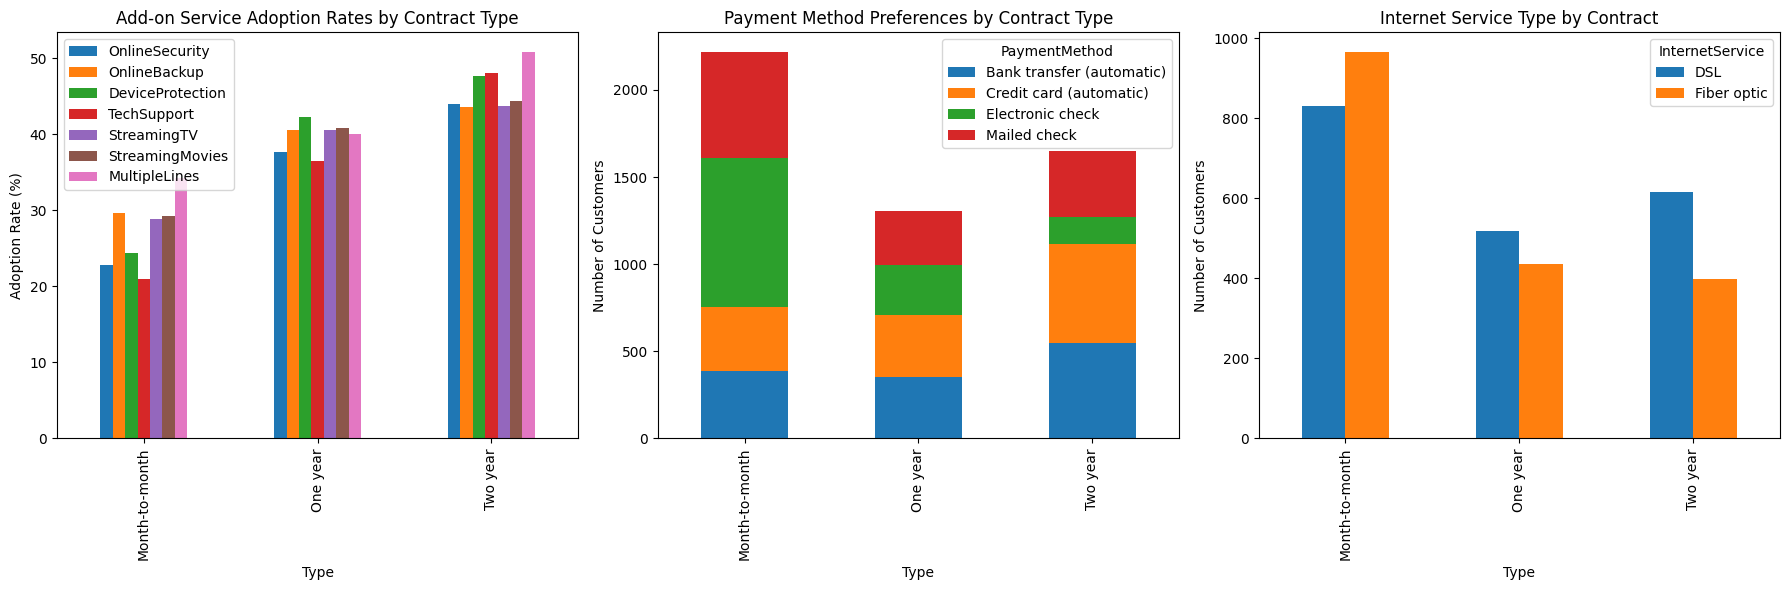

In [12]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (iii & iv) - Create sensitivity visualizations

# Create a comparison chart
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Chart 1: Add-on adoption rates by contract type
addon_rates = active_full.groupby('Type')[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].apply(
    lambda x: (x == 'Yes').mean() * 100
)

addon_rates.plot(kind='bar', ax=ax1)
ax1.set_title('Add-on Service Adoption Rates by Contract Type')
ax1.set_ylabel('Adoption Rate (%)')
ax1.legend(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'])

# Chart 2: Payment method preferences
payment_prefs = active_full.groupby(['Type', 'PaymentMethod']).size().unstack()
payment_prefs.plot(kind='bar', ax=ax2, stacked=True)
ax2.set_title('Payment Method Preferences by Contract Type')
ax2.set_ylabel('Number of Customers')

# Chart 3: Internet service adoption by contract type
internet_breakdown = active_full.groupby(['Type', 'InternetService']).size().unstack()
internet_breakdown.plot(kind='bar', ax=ax3)
ax3.set_title('Internet Service Type by Contract')
ax3.set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()


In [13]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (iii & iv) - Create sensitivity visualizations

# Create demographic risk breakdown for ACTIVE customers only
active_risk_data = full_data[full_data['EndDate'] == 'No']

# 1. Senior Citizen Risk Analysis
print("=== CHURN RISK BY SENIOR CITIZEN STATUS ===")
senior_risk = active_risk_data.groupby(['SeniorCitizen', 'churn_risk']).size().unstack(fill_value=0)
print(senior_risk)
print()

# Calculate percentages
senior_risk_pct = active_risk_data.groupby('SeniorCitizen')['churn_risk'].value_counts(normalize=True) * 100
print("Percentages by Senior Citizen Status:")
print(senior_risk_pct)
print()

=== CHURN RISK BY SENIOR CITIZEN STATUS ===
churn_risk     High Risk  Low Risk  Medium Risk  Very High Risk
SeniorCitizen                                                  
0                    342      3802          161             203
1                     69       488           53              56

Percentages by Senior Citizen Status:
SeniorCitizen  churn_risk    
0              Low Risk          84.338953
               High Risk          7.586513
               Very High Risk     4.503106
               Medium Risk        3.571429
1              Low Risk          73.273273
               High Risk         10.360360
               Very High Risk     8.408408
               Medium Risk        7.957958
Name: churn_risk, dtype: float64



<Figure size 1000x600 with 0 Axes>

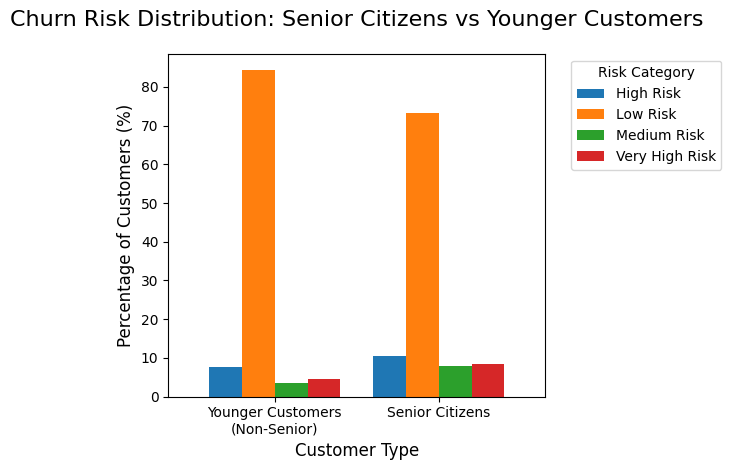

In [14]:
## DATA PREPARATION
##  OUTLINE 3 - Combine all Data Frames
##  QUESTION #2 - Explore Expanded Insight:
##  Answer (iii & iv) - Create sensitivity visualizations

#  Visualization of the data above

# Create the percentage data in the right format for plotting
senior_risk_viz = active_risk_data.groupby('SeniorCitizen')['churn_risk'].value_counts(normalize=True) * 100

# Convert to DataFrame for easier plotting
risk_comparison = senior_risk_viz.unstack()

# Create the plot
plt.figure(figsize=(10, 6))
risk_comparison.plot(kind='bar', width=0.8)
plt.title('Churn Risk Distribution: Senior Citizens vs Younger Customers', fontsize=16, pad=20)
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Percentage of Customers (%)', fontsize=12)
plt.xticks([0, 1], ['Younger Customers\n(Non-Senior)', 'Senior Citizens'], rotation=0)
plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
## DATA PREPARATION
##  OUTLINE 4 - Analyze Date Ranges
##  QUESTION #3 - Date Period Ranges:
##  Answer (i, ii) - sort_values(by='BeginDate')

##  FIRST ACTIVE CUSTOMER "BEGIN" DATE:  2014-02-01
##  MOST CURRENT ACTIVE CUSTOMER "BEGIN" DATE:  2020-02-01
print('ACTIVE Customers:')
print('Oldest Active BeginDate:')
print(active_full.sort_values(by='BeginDate', ascending=True, na_position='last').head(1)[['customerID', 'BeginDate', 'EndDate', 'tenure_days']])
print()
print('Most Current Active BeginDate:')
print(active_full.sort_values(by='BeginDate', ascending=False, na_position='last').head(1)[['customerID', 'BeginDate', 'EndDate', 'tenure_days']])
print()
print()

# Analyze CHURNED customers
df_churned_customers = full_data[full_data['EndDate'] != 'No']

print('CHURNED (Inactive) Customers:')
print('Oldest Inactive EndDate:')
print(df_churned_customers.sort_values(by='EndDate_datetime', ascending=True, na_position='last').head(1)[['customerID', 'BeginDate', 'EndDate_datetime', 'churn_days']])
print()
print('Most Current Inactive EndDate:')
print(df_churned_customers.sort_values(by='EndDate_datetime', ascending=False, na_position='last').head(1)[['customerID', 'BeginDate', 'EndDate_datetime', 'churn_days']])


ACTIVE Customers:
Oldest Active BeginDate:
     customerID            BeginDate EndDate  tenure_days
746  6919-ELBGL  2014-02-01 00:00:00      No       2191.0

Most Current Active BeginDate:
      customerID            BeginDate EndDate  tenure_days
4380  2520-SGTTA  2020-02-01 00:00:00      No          0.0


CHURNED (Inactive) Customers:
Oldest Inactive EndDate:
      customerID            BeginDate EndDate_datetime  churn_days
3580  0260-ZDLGK  2019-01-01 00:00:00       2019-10-01       273.0

Most Current Inactive EndDate:
      customerID            BeginDate EndDate_datetime  churn_days
2086  2955-BJZHG  2018-08-01 00:00:00       2020-01-01       518.0


In [16]:
## DATA PREPARATION
##  OUTLINE 4 - Analyze Date Ranges
##  QUESTION #4 - Tenure Distribution:
##  Answer (i, ii, iii) - sort_values(by='BeginDate')

# Get basic statistics for tenure
print("Tenure Distribution Summary:")
print(df_contract['tenure_days'].describe())

Tenure Distribution Summary:
count    5174.000000
mean     1144.447236
std       733.897937
min         0.000000
25%       457.000000
50%      1157.000000
75%      1857.000000
max      2191.000000
Name: tenure_days, dtype: float64


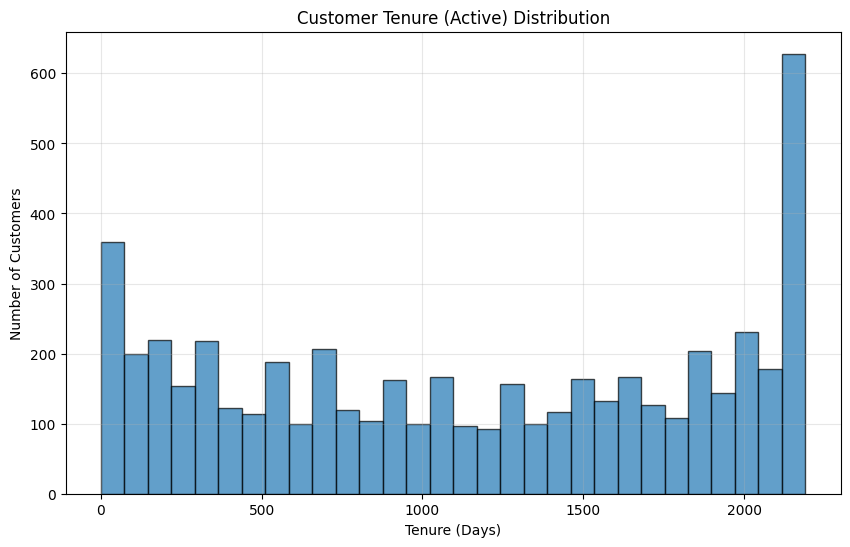

In [17]:
## DATA PREPARATION
##  OUTLINE 4 - Analyze Date Ranges
##  QUESTION #4 - Tenure Distribution:
##  Answer (i, ii, iii) - sort_values(by='BeginDate')

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_contract['tenure_days'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Customer Tenure (Active) Distribution')
plt.xlabel('Tenure (Days)')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)
plt.show()

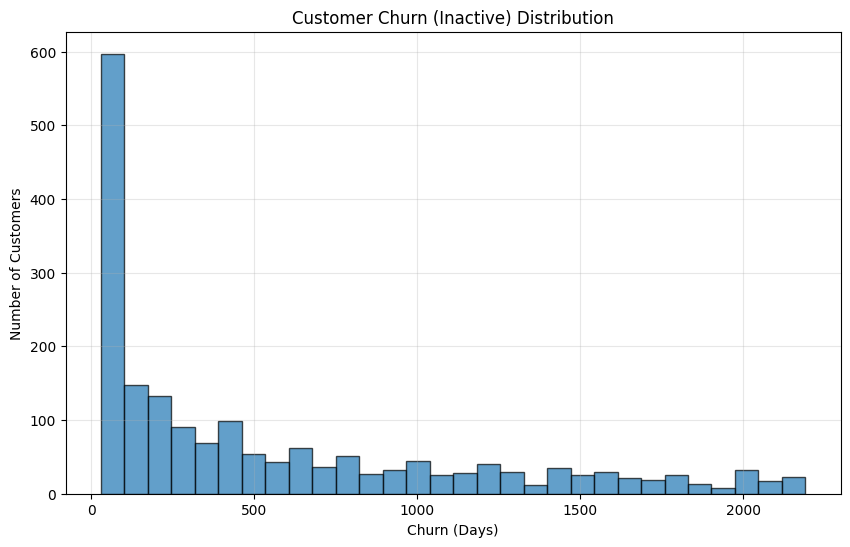

In [18]:
## DATA PREPARATION
##  OUTLINE 4 - Analyze Date Ranges
##  QUESTION #4 - Tenure Distribution:
##  Answer (i, ii, iii) - sort_values(by='BeginDate')

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_contract['churn_days'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Customer Churn (Inactive) Distribution')
plt.xlabel('Churn (Days)')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)
plt.show()

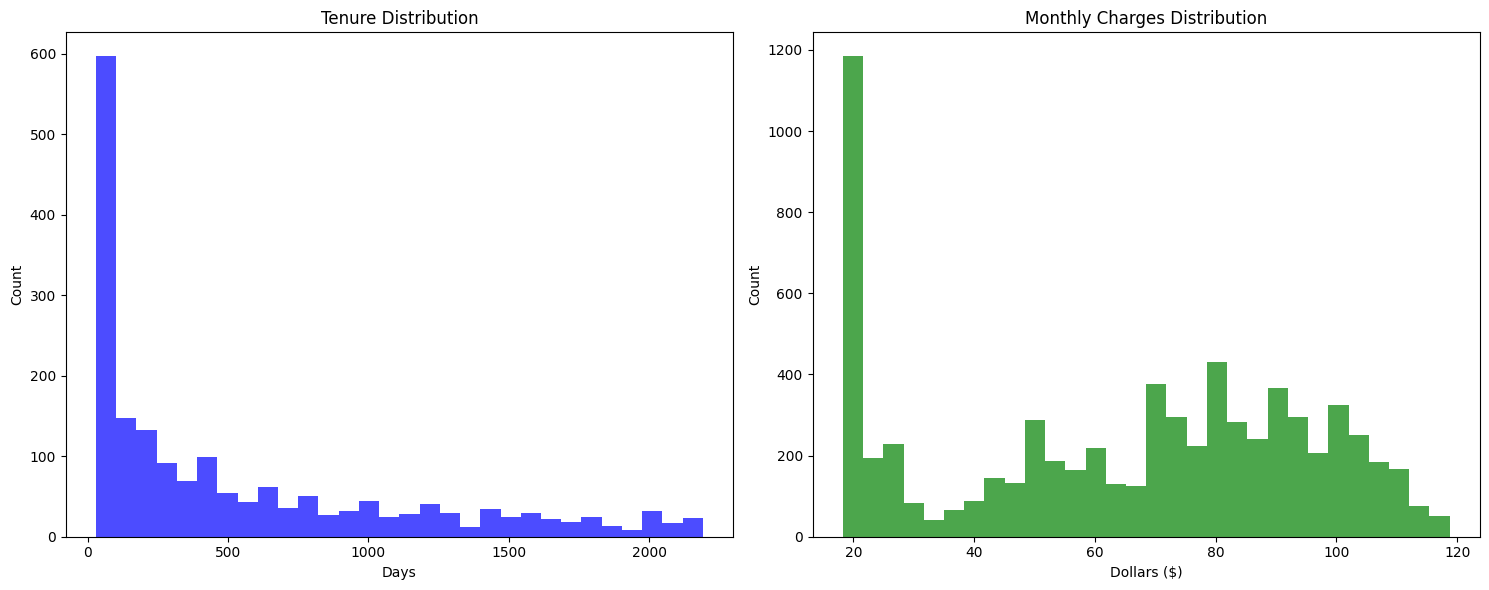

In [19]:
## DATA PREPARATION
##  OUTLINE 4 - Analyze Date Ranges
##  QUESTION #4 - Tenure Distribution:
##  Answer (i, ii, iii) - sort_values(by='BeginDate')

#Option 1: Side-by-Side Distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Tenure distribution
ax1.hist(df_contract['churn_days'].dropna(), bins=30, alpha=0.7, color='blue')
ax1.set_title('Tenure Distribution')
ax1.set_xlabel('Days')
ax1.set_ylabel('Count')

# Monthly charges distribution
ax2.hist(df_contract['MonthlyCharges'].dropna(), bins=30, alpha=0.7, color='green')
ax2.set_title('Monthly Charges Distribution')
ax2.set_xlabel('Dollars ($)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

DESCRIBE():
count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: churn_days, dtype: float64


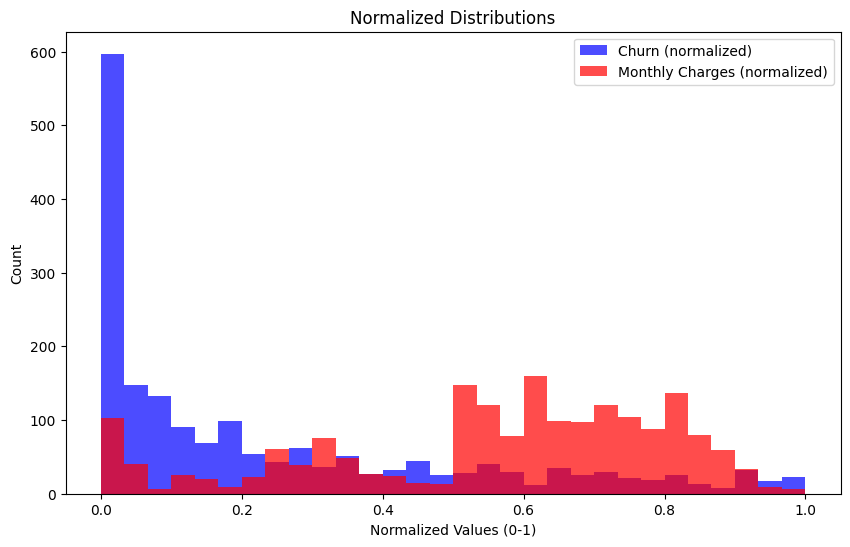

In [20]:
## DATA PREPARATION
##  OUTLINE 4 - Analyze Date Ranges
##  QUESTION #4 - Tenure Distribution:
##  Answer (i, ii, iii) - sort_values(by='BeginDate')

print('DESCRIBE():')
print(df_contract['churn_days'].sort_values(ascending=False).describe())

# Normalize both to 0-1 scale for comparison
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_contract[['churn_days', 'MonthlyCharges']].dropna())

plt.figure(figsize=(10, 6))
plt.hist(normalized_data[:, 0], bins=30, alpha=0.7, label='Churn (normalized)', color='blue')
plt.hist(normalized_data[:, 1], bins=30, alpha=0.7, label='Monthly Charges (normalized)', color='red')
plt.xlabel('Normalized Values (0-1)')
plt.ylabel('Count')
plt.title('Normalized Distributions')
plt.legend()
plt.show()

#### Section 1 - Clarifying Questions:
    Question 1:  
        a) What patterns are found about the data by using data description (EDA) functions? 
            E.g. info(), describe(), head(0) 
            i)   From a total 7043 customers, 5174 (~74%) are still active, 1869 (~26) churned
            ii)  df_internet and df_phone have less rows than total, suggesting missing values
 
    Question 2:
       a) What expanded insight can be seen after merging customer datasets?
            [ E.g. totals for active customers grouped by contract type ]
            i)    Month-to-month 2220 (~43%); two-year 1647 (~32%); one-year 1307 (~25%) totals
            ii)   Month-to-month customers are 4x more likely to use electronic checks 
            iii)  Month-to-month are price sensitive, services without longterm commitment
            iv)   Two year customers are value-seekers, liking add-ons, and stability oriented
             
    Question 3:
        a) What date periods do the datasets cover?
            i)   2013-10-01 to 2020-02-01 is the date range for all customers
            ii)  2014-02-01 to 2020-02-01 is the date range for active customers (no EndDate)
            iii) 2019-10-01 to 2020-01-01 is the range for churned customers (1st EndDate and last EndDate)
           
     Question 4:
        a) What does the histogram distribution reveal about tenure_days by customer count?
            i)   Most churned customers left within their first few months
            ii)  Churned customers came from across all price point segments
            iii) Early tenure is the highest risk period

     Question 5:
        a) What accuracy threshold defines "success" for this model?
            i)   Per the Project Summary, an AUC-ROC between 0.75 to 0.88
            ii)  Additional metric is Accuracy


In [21]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 1 - Fix Data Types
##  TASK 1(a) - TotalCharges Type

full_data['TotalCharges'] = pd.to_numeric(full_data['TotalCharges'], errors='coerce')
print(full_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   object        
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   tenure_days       5174 non-null   float64       
 9   EndDate_datetime  1869 non-null   datetime64[ns]
 10  churn_days        1869 non-null   float64       
 11  churn_risk        7043 non-null   object        
 12  tenure_category   7043 non-null   object        
 13  gender            7043 non-null   object        
 14  SeniorCitizen     7043 n

In [22]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 1 - Missing Customers
##  TASK 1(b) - Missing values

# Remove the 11 brand new customers for model training
print(f"Before removal: {len(full_data)} customers")
full_data_clean = full_data.dropna(subset=['TotalCharges'])
print(f"After removal: {len(full_data_clean)} customers")
print(f"Removed: {len(full_data) - len(full_data_clean)} customers")

# Verify the removal
print(f"\nTotalCharges missing values: {full_data_clean['TotalCharges'].isna().sum()}")

Before removal: 7043 customers
After removal: 7032 customers
Removed: 11 customers

TotalCharges missing values: 0


In [23]:
##  SECTION #2
##  SECTION #2

In [24]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 2 - Binary Target and Feature Matrix Creation
##  TASK 1(a) - Binary Target (Churn Indicator)

# Create a proper independent copy
full_data_clean = full_data.dropna(subset=['TotalCharges']).copy()

# Create the binary churn indicator
full_data_clean['churn'] = (full_data_clean['EndDate'] != 'No').astype(int)

# Verify it worked
print("Churn distribution:")
print(full_data_clean['churn'].value_counts())
print(f"Churn rate: {full_data_clean['churn'].mean():.2%}")

Churn distribution:
0    5163
1    1869
Name: churn, dtype: int64
Churn rate: 26.58%


In [25]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 2 - Binary Target and Feature Matrix Creation
##  TASK 1(b) - Feature Matrix

# Predictive Features
features = ['Type', 'MonthlyCharges', 'PaperlessBilling', 'PaymentMethod', 
           'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents',
           'InternetService', 'OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


In [26]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 2 - Binary Target and Feature Matrix Creation
##  TASK 1(c) - Create X, Y variables

# Create feature matrix and target variable
X = full_data_clean[features].copy()
y = full_data_clean['churn'].copy()


In [27]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 2 - Binary Target and Feature Matrix Creation
##  TASK 1(d) - Check and handle Missing Values

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nMissing values in features:")
print(X.isnull().sum())

# Handle missing internet service features
internet_features = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Fill missing values with "No Internet Service"
for feature in internet_features[1:]:  # Skip InternetService itself
    X[feature] = X[feature].fillna('No Internet Service')

# For InternetService, fill with "No"
X['InternetService'] = X['InternetService'].fillna('No')

# Verify missing values
print()
print("After handling missing values:")
print(X.isnull().sum())

Feature matrix shape: (7032, 15)
Target variable shape: (7032,)

Missing values in features:
Type                   0
MonthlyCharges         0
PaperlessBilling       0
PaymentMethod          0
TotalCharges           0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64

After handling missing values:
Type                0
MonthlyCharges      0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [28]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 3 - Category Encoding
##  TASK (a) - Check for categorical features

# Check your categorical feature distributions
print("Categorical feature unique values:")
for col in X.select_dtypes(include=['object']).columns:
    print(f"\n{col}: {X[col].unique()}")

Categorical feature unique values:

Type: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: ['Yes' 'No']

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No Internet Service']

OnlineBackup: ['Yes' 'No' 'No Internet Service']

DeviceProtection: ['No' 'Yes' 'No Internet Service']

TechSupport: ['No' 'Yes' 'No Internet Service']

StreamingTV: ['No' 'Yes' 'No Internet Service']

StreamingMovies: ['No' 'Yes' 'No Internet Service']


In [29]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 3 - Category Encoding
##  TASK (b) - Mixed Encoding

# Create a copy for encoding
X_encoded = X.copy()

# 1. ORDINAL ENCODING for contract Type (natural order)
type_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
X_encoded['Type'] = X_encoded['Type'].map(type_mapping)

# 2. BINARY ENCODING for Yes/No features (more efficient than one-hot)
binary_features = ['PaperlessBilling', 'Partner', 'Dependents']
for feature in binary_features:
    X_encoded[feature] = (X_encoded[feature] == 'Yes').astype(int)

# 3. ONE-HOT ENCODING for multi-category features (no natural order)
categorical_features = ['PaymentMethod', 'InternetService']
X_encoded = pd.get_dummies(X_encoded, columns=categorical_features, prefix=categorical_features)

# 4. CUSTOM ENCODING for service features (3-way relationship)
service_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

for feature in service_features:
    # Create two binary columns: has_service and has_internet
    X_encoded[f'{feature}_Yes'] = (X_encoded[feature] == 'Yes').astype(int)
    X_encoded[f'{feature}_HasInternet'] = (X_encoded[feature] != 'No Internet Service').astype(int)
    # Drop original column
    X_encoded.drop(feature, axis=1, inplace=True)

print("Encoded feature shape:", X_encoded.shape)
print()
print("New feature columns:", X_encoded.columns.tolist())

print()
print('ENCODED INFO():')
print(X_encoded.info())


Encoded feature shape: (7032, 26)

New feature columns: ['Type', 'MonthlyCharges', 'PaperlessBilling', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineSecurity_HasInternet', 'OnlineBackup_Yes', 'OnlineBackup_HasInternet', 'DeviceProtection_Yes', 'DeviceProtection_HasInternet', 'TechSupport_Yes', 'TechSupport_HasInternet', 'StreamingTV_Yes', 'StreamingTV_HasInternet', 'StreamingMovies_Yes', 'StreamingMovies_HasInternet']

ENCODED INFO():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Type                                     703

In [30]:
## DATA CLEANING (MODEL PRE-PROCESSING)
##  OUTLINE 3 - Category Encoding
##  TASK (c) - Verify Encoding by value_counts()

# Let's check a few key encodings
print("Type encoding check:")
print(X_encoded['Type'].value_counts().sort_index())
print("\nService feature example (OnlineSecurity):")
print("OnlineSecurity_Yes:", X_encoded['OnlineSecurity_Yes'].value_counts())
print("OnlineSecurity_HasInternet:", X_encoded['OnlineSecurity_HasInternet'].value_counts())

Type encoding check:
0    3875
1    1472
2    1685
Name: Type, dtype: int64

Service feature example (OnlineSecurity):
OnlineSecurity_Yes: 0    5017
1    2015
Name: OnlineSecurity_Yes, dtype: int64
OnlineSecurity_HasInternet: 1    5512
0    1520
Name: OnlineSecurity_HasInternet, dtype: int64


In [31]:
## MODEL TRAINING
##  OUTLINE 1 - Create train-test split
##  TASK (a) - Split the data into a TRAINING, VALIDATION and TEST set (3:1:1 Model - 60%, 20% 20%)

# First split: separate test set (80% train+valid, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,      # 20% for test
    random_state=42,    
    stratify=y          
)

# Second split: divide remaining into train and validation (75% train, 25% valid of the 80%)
# This gives us final split of: 60% train, 20% valid, 20% test
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp,
    test_size=0.25,     # 25% of 80% = 20% of total
    random_state=42,    
    stratify=y_temp     # Stratify on the subset, not full y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_valid.shape[0]} samples") 
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Validation churn rate: {y_valid.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

Training set: 4218 samples
Validation set: 1407 samples
Test set: 1407 samples
Training churn rate: 26.58%
Validation churn rate: 26.58%
Test churn rate: 26.58%


In [32]:
## MODEL TRAINING
##  OUTLINE 2 - Create Random Forest Model
##  TASK (a) - Random Forest Model

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,    # Good starting point
    random_state=42,     # Reproducibility
    max_depth=10,        # Prevent overfitting
    min_samples_split=20 # Robust splits
)

# Time the training
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

Training completed in 0.25 seconds


In [33]:
## MODEL TRAINING
##  OUTLINE 2 - Create Random Forest Model
##  TASK (b) - Model Evaluation

# Make predictions
y_pred = rf_model.predict(X_valid)
y_pred_proba = rf_model.predict_proba(X_valid)[:, 1]

# Calculate comprehensive metrics
accuracy = accuracy_score(y_valid, y_pred)
auc_score = roc_auc_score(y_valid, y_pred_proba)

print("=== RANDOM FOREST MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC-ROC: {auc_score:.3f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_pred))
print()
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

=== RANDOM FOREST MODEL PERFORMANCE ===
Accuracy: 0.787
AUC-ROC: 0.834

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1033
           1       0.25      0.18      0.21       374

    accuracy                           0.64      1407
   macro avg       0.49      0.49      0.49      1407
weighted avg       0.60      0.64      0.62      1407


Confusion Matrix:
[[828 205]
 [306  68]]


In [34]:
## MODEL TRAINING
##  OUTLINE 2 - Create Random Forest (GridSearchCV) Model
##  TASK (c) - GridSearchCV Model and Evaluation

# This TRAINS multiple models to find best hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,                    
    scoring='f1',
    n_jobs=-1
)

# Use only training data
grid_search.fit(X_train, y_train)  
best_model = grid_search.best_estimator_

# This EVALUATES final model on unseen validation data
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

# Calculate multiple metrics
print("=== VALIDATION PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_valid, y_valid_pred):.3f}")
print(f"F1-Score: {f1_score(y_valid, y_valid_pred):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_valid, y_valid_proba):.3f}")
print(f"Precision: {precision_score(y_valid, y_valid_pred):.3f}")
print(f"Recall: {recall_score(y_valid, y_valid_pred):.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred))

=== VALIDATION PERFORMANCE ===
Accuracy: 0.775
F1-Score: 0.601
AUC-ROC: 0.830
Precision: 0.568
Recall: 0.639

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1033
           1       0.57      0.64      0.60       374

    accuracy                           0.77      1407
   macro avg       0.72      0.73      0.72      1407
weighted avg       0.78      0.77      0.78      1407



In [35]:
## MODEL TRAINING
##  OUTLINE 2 - Create Random Forest (GridSearchCV) Model
##  TASK (d) - GridSearchCV Model and Evaluation
##  FINAL METRICS:  PREDICT USING X_TEST DATASET (ONLY ONCE)

# This EVALUATES final model on unseen validation data
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate multiple metrics
print("=== FINAL TEST DATASET - VALIDATION PERFORMANCE ===")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

=== FINAL TEST DATASET - VALIDATION PERFORMANCE ===
AUC-ROC: 0.826
Accuracy: 0.766
F1-Score: 0.616
Precision: 0.547
Recall: 0.706

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.55      0.71      0.62       374

    accuracy                           0.77      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.77      0.77      1407



=== TOP 10 MOST IMPORTANT FEATURES ===
                           feature  importance
3                     TotalCharges    0.239847
0                             Type    0.187254
1                   MonthlyCharges    0.109410
12     InternetService_Fiber optic    0.085206
9   PaymentMethod_Electronic check    0.055708
14              OnlineSecurity_Yes    0.039716
20                 TechSupport_Yes    0.035174
11             InternetService_DSL    0.028505
19    DeviceProtection_HasInternet    0.018690
2                 PaperlessBilling    0.018599


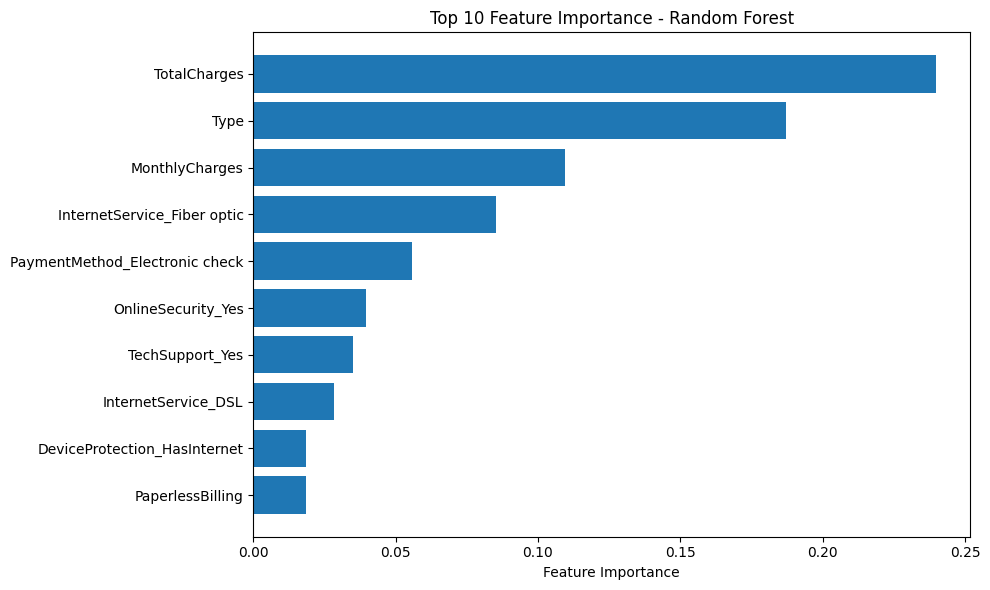

In [36]:
## MODEL TRAINING
##  OUTLINE 2 - Create Random Forest Model
##  TASK (e) - Feature Analysis

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

# Visualize top features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Section 2 - Work Plan:
        Step 1: Data Exploration and Cleaning
            a) address any missing values
            b) update object/column types, if needed
            
        Step 2:  Feature Engineering
            a) develop tenure categories
            b) add derived variables (e.g. churn_days, tenure_days)
            
        Step 3:  Model Development
            a)  many features in the dataset are good for Classification 
                - Contract Type (Month-to-Month, One Year, Two Year)
                - PaperlessBilling (Yes/No)
                - PaymentMethod (4 categories)
                - gender (Male/Female)
                - SeniorCitizen (0/1)
                - InternetService (3 Categories)
                - TechSupport (Yes/No)  
            b)  use Boosting algorithms if needed to improve the prediction power of the model
            
        Step 4: Business Recommendations
            a)  measure and assess Accuracy metric (AUC-ROC)
            b)  translate findings and recommend actionable strategies            

#### Solution Report:
        Tasks Performed
        Step 1: Data Exploration and Cleaning
            a)  Discovered missing values in df_phone, df_internet
            b)  Addressed missing values

        Step 2: Feature Engineering
            a)  Added new column 'tenure_days' ('snapshot_date' - 'BeginDate')
            b)  Added new column 'churn_days' ('EndDate' - 'BeginDate')
            c)  Added new column 'churn_risk' 
                -  'High Risk', 'Low Risk', based on 'tenure_days' and 'MonthlyCharges' ranges
            d)  Added new column 'tenure_category' ('New', 'Established', based on number of days)
            e)  Created distribution plots (Add-on services, Payment Method, Internet by Contract Type)

            Challenges:
                a)  Analysis discovered 11 brand new Customers missing values in df_internet.
                    -  Customers dropped since they had not accumulated any monthly charges
                    -  these Empty records were not going to help in the model prediction
                b)  Feature Encoding required a mixed approach
                    - ordinal encoding for contract types
                    - binary for Yes/No features
                    - one-hot encoding for multi-category features

        Step 3:  Model Development
            a)  Logistic Regression had been the model of choice before EDA
            b)  Random Forest is the model of choice for a good balance of interpretability and performance
            c)  Boosting algorithms were not used because the model metrics fell within the required range

        Step 4:  Business Recommendations
             a)  NOTE:  Final Results use un-seen TEST dataset (Model recall 70.6%)
                -  AUC-ROC: 0.826
                -  Accuracy: 0.766
                -  Recall: 0.706
                -  F1-Score: 0.616
                -  Precision: 0.547
                -  Classification Report (attached)
            b)  Business Findings:
                -  Month-to-month Customers have the highest churn risk
                -  Month-to-month Customers are sensitive to high pricing
                -  Electronic check Customers present a red flag for possible churning
                -  Low service adoption ('OnlineSecurity', 'DeviceProtection', etc) has higher churn risk
            c)  Actionable Recommendations:
                -  First 6 months is highest churn risk period, offer discounts for first year Customers
                -  Offer discounts to Month-to-month Customers for switching to one-year contracts
                -  Proactively contact electronic check customers, provide payment method education/support
                -  Offer bundled security packages at discounted rates, educate on cybersecurity benefits
                -  Offer service bundles and loyalty discounts for long-term customers
                -  Implement monthly churn risk assessment reports, and report intervention success rates